In [1]:
# Uncomment below if you want to run this file only
%run main.ipynb
#%run data_cleaning.ipynb
#%run data_visualization.ipynb
#%run feature_engineering.ipynb

d:\Users\presc\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read the CSV From FEATURE ENGINEERING data source file from S3 into a DataFrame
# Use the methods from the S3Utils class
if s3_utils.check_file_exists(output_file_key_data_feature_engineering):
    dataset = s3_utils.read_csv_from_s3(output_file_key_data_feature_engineering)

In [3]:
X = dataset.drop('target', axis=1)
y = dataset['target']

In [4]:
# Double check for missing values
X.isna().sum()


id                                0
amount_rub_clo_prc            38323
amount_rub_sup_prc            38323
rest_dynamic_save_3m              0
rest_avg_cur                      0
amount_rub_nas_prc            38323
amount_rub_atm_prc            38323
rest_dynamic_fdep_3m              0
rest_avg_paym                     0
ldeal_grace_days_pct_med          0
rest_dynamic_cur_3m               0
rest_dynamic_paym_3m              0
rest_dynamic_il_3m                0
rest_dynamic_cc_3m                0
pack_encoded                      0
number_products                   0
new_age_category_numeric          0
new_setup_tenor                   0
total_turnover_category           0
total_turnover_1m_category        0
total_turnover_3m_category        0
dtype: int64

In [5]:
X.drop(['amount_rub_clo_prc','amount_rub_sup_prc','amount_rub_nas_prc'] ,  axis=1, inplace=True )

In [6]:
# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Convert the imputed data back to a DataFrame
X = pd.DataFrame(X_imputed, columns=X.columns)

In [7]:
X.shape

(355190, 18)

In [8]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [9]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Apply SMOTE oversampling
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

In [11]:
# Train the SVM model using LinearSVC
linearsvc_model = LinearSVC(class_weight='balanced', dual=False, random_state=42)

linearsvc_param_distributions = {
    'C': [0.1, 1, 10, 100],  # [0.1, 1, 10, 100] Regularization parameter
    'loss': ['squared_hinge'],  # Specifies the loss function
    'max_iter': [1000, 5000, 10000]  # Maximum number of iterations
}

In [12]:
from sklearn.model_selection import RandomizedSearchCV

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    linearsvc_model,
    param_distributions=linearsvc_param_distributions,
    n_iter=10,                         # Number of parameter settings sampled
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

In [13]:
# Fit the model
random_search.fit(X_train, y_train)


In [ ]:
# Make predictions
y_pred = random_search.predict(X_test)

In [ ]:
# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

In [ ]:
# Print the scores
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Accuracy: 0.5438
Precision: 0.1210
Recall: 0.7354
F1 Score: 0.2079
AUC-ROC: 0.6312


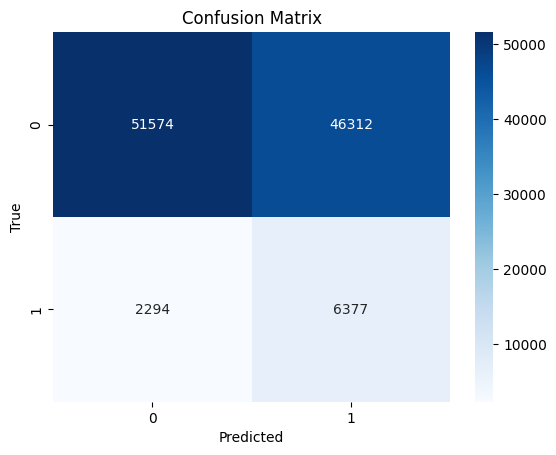

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

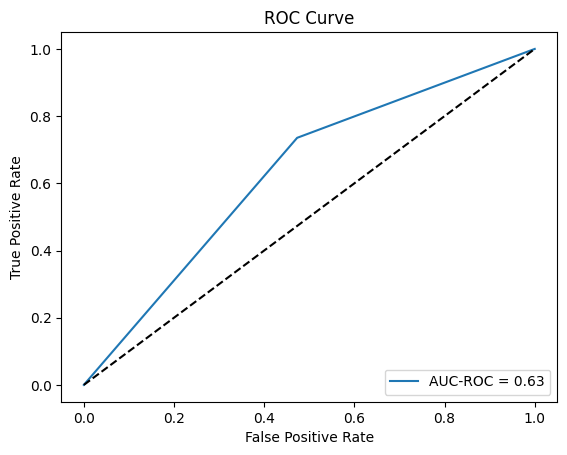

In [ ]:
# ROC Curve and AUC-ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC-ROC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The ROC (Receiver Operating Characteristic) curve provided is a graphical representation that shows the diagnostic ability of a binary classifier system as its discrimination threshold is varied. For the bank churn prediction dataset, the ROC curve and the AUC (Area Under the Curve) score are used to evaluate the performance of the classification model. Here’s what this specific ROC curve and the AUC-ROC value tell's the model:

1. **ROC Curve Shape**: The blue line represents the performance of the classification model. A perfect classifier would have a line going from the bottom left to the top left and then across to the top right (a right angle). The curve is above the dashed line (which represents random chance), indicating that the model has learned something meaningful.

2. **AUC-ROC Value**: The AUC-ROC value is 0.62, which is a measure of the area under the ROC curve. The value ranges from 0.5 (no discrimination ability) to 1.0 (perfect discrimination ability). A score of 0.62 suggests that the model is able to discriminate between the positive class (customers who churn) and the negative class (customers who don't churn) better than random chance, but it's not a strong model. Usually, an AUC-ROC score above 0.7 is considered acceptable, above 0.8 is considered excellent, and above 0.9 is outstanding.

Based on this chart, the model has room for improvement. To enhance model performance:

- Gathering more features that could help in predicting churn.
- Trying different preprocessing techniques.
- Experimenting with different models and algorithms.
- Tuning hyperparameters more finely.
- Utilizing more advanced techniques like ensemble methods.

will look for other metrics such as precision, recall, and F1 score, especially because the dataset is imbalanced. These metrics can provide additional insights into the model's performance, particularly in how it handles the minority class (churned customers).